# Mechanistic modeling of VMHvl line attractor dynamics

By Charles Xu @ Caltech, 2024.

This notebook builds on the work by Isa in 2024 to further generalize on other plausible mechanisms of the implementation of the VMHvl line attractor.

## Environment

In [1]:
from netpyne import specs, sim
import numpy as np
import matplotlib.pyplot as plt

## Neuron model

In [2]:
# Parameters
N = 1000
thr = 0.09
g_input = 6
dt = 0.005  # s
tau = 0.1  # s

# Create a NetParams object to store network parameters
netParams = specs.NetParams()

# Define cell properties
netParams.cellParams['IF_cell'] = {
    'conds': {'cellType': 'IF', 'cellModel': 'IntFire1'},
    'secs': {'soma': {'pointps': {'IntFire1': {'tau': 100, 'refrac': 1}}}}
}


## Network topology

In [3]:
## Connectivity parameters

N = 1000
x1_percentage = 0.5  # Example percentage, adjust as needed
x2_percentage = 0.5

num_x1_neurons = int((N / 5) * x1_percentage)
num_x2_neurons = int((N / 5) * x2_percentage)
num_other_neurons = N - num_x1_neurons - num_x2_neurons

# Create populations
netParams.popParams['x1'] = {'cellType': 'IF', 'numCells': num_x1_neurons}
netParams.popParams['x2'] = {'cellType': 'IF', 'numCells': num_x2_neurons}
netParams.popParams['other'] = {'cellType': 'IF', 'numCells': num_other_neurons}

In [4]:
# Initialize random connectivity
# General connectivity parameters
prob_connection = 0.01
weight = 1.0 / np.sqrt(N)
delay = 1  # ms

# Define synaptic mechanism
netParams.synMechParams['exc'] = {'mod': 'ExpSyn', 'tau': 2, 'e': 0}

# Connect neurons randomly with specified probability
netParams.connParams['randConnect'] = {
    'preConds': {'pop': ['x1', 'x2', 'other']},
    'postConds': {'pop': ['x1', 'x2', 'other']},
    'probability': prob_connection,
    'weight': weight,
    'delay': delay,
    'synMech': 'exc'
}

In [5]:
## Subnetwork connectivity

N_sub = int(0.2 * N)  # Subnetwork size
prob_subnet = 0.38

# Connect neurons within the subnetwork
netParams.connParams['subnetConnect'] = {
    'preConds': {'pop': ['x1']},  # Assuming x1 neurons form the subnetwork
    'postConds': {'pop': ['x1']},
    'probability': prob_subnet,
    'weight': weight,
    'delay': delay,
    'synMech': 'exc'
}

## Input

In [6]:
## Input parameters

tOn = 2.5 * 1e3  # Convert to ms
tOff = 4.5 * 1e3
stim_times = [tOn, tOff]

# Additional pulses at specified times
additional_pulses = [(24.5, 26.5), (46.5, 48.5), (68.5, 70.5)]
for pulse in additional_pulses:
    t_start = pulse[0] * 1e3
    t_end = pulse[1] * 1e3
    stim_times.extend([t_start, t_end])

In [7]:
# External input parameters
netParams.stimSourceParams['inputStim'] = {'type': 'NetStim', 'interval': 1e9,
                                           'number': 1, 'start': tOn, 'noise': 0}

# Connect the NetStim to x1 and x2 neurons
netParams.stimTargetParams['inputStim->x1'] = {
    'source': 'inputStim',
    'conds': {'pop': 'x1'},
    'weight': g_input,
    'delay': 0,
    'synMech': 'exc'
}

netParams.stimTargetParams['inputStim->x2'] = {
    'source': 'inputStim',
    'conds': {'pop': 'x2'},
    'weight': g_input,
    'delay': 0,
    'synMech': 'exc'
}

## Simulation

In [8]:
simConfig = specs.SimConfig()

# Simulation parameters
simConfig.duration = 200 * 1e3  # Simulation time in ms
simConfig.dt = dt * 1e3  # Timestep in ms

# Recording options
simConfig.recordTraces = {
    'V_soma': {'sec': 'soma', 'loc': 0.5, 'var': 'v'}
}

simConfig.recordStep = 0.1  # Step size in ms
simConfig.filename = 'hypothalamic_sim'  # Set filename
simConfig.saveJson = True  # Save to JSON for analysis

# Analysis and plotting
simConfig.analysis['plotRaster'] = {'orderBy': 'pop', 'popRates': True}
simConfig.analysis['plotTraces'] = {'include': [('x1', 0), ('x2', 0)]}
simConfig.analysis['plotSpikeStats'] = {'stats': ['rate', 'isicv', 'sync']}

In [9]:
# Set a random seed for reproducibility if needed
simConfig.hParams['randseed'] = 1


Start time:  2024-09-17 16:46:00.598562

Creating network of 3 cell populations on 1 hosts...
  Number of cells on node 0: 1000 
  Done; cell creation time = 0.07 s.
Making connections...
  Number of connections on node 0: 0 
  Done; cell connection time = 1.58 s.
Adding stims...
  Number of stims on node 0: 0 
  Done; cell stims creation time = 0.00 s.
Recording 0 traces of 0 types on node 0

Running simulation using NEURON for 200000.0 ms...
  Done; run time = 0.08 s; real-time ratio: 2545.17.

Gathering data...
  Done; gather time = 0.06 s.

Analyzing...
  Cells: 1000
  Connections: 0 (0.00 per cell)
  Spikes: 0 (0.00 Hz)
  Simulated time: 200.0 s; 1 workers
  Run time: 0.08 s
Saving output as hypothalamic_sim_data.json ... 
Finished saving!
  Done; saving time = 1.10 s.
Preparing spike data...

There was an exception in prepareSpikeData()
Plotting raster...

There was an exception in plotRaster()
Plotting recorded cell traces ... cell


Traceback (most recent call last):
  File "/home/charlesxu/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/netpyne/analysis/utils.py", line 87, in wrapper
    return function(*args, **kwargs)
  File "/home/charlesxu/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/netpyne/analysis/spikes.py", line 86, in prepareSpikeData
    df['popInd'].cat.set_categories(sim.net.pops.keys(), inplace=True)
  File "/home/charlesxu/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/pandas/core/accessor.py", line 112, in f
    return self._delegate_method(name, *args, **kwargs)
  File "/home/charlesxu/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/pandas/core/arrays/categorical.py", line 2941, in _delegate_method
    res = method(*args, **kwargs)
TypeError: set_categories() got an unexpected keyword argument 'inplace'
Traceback (most recent call last):
  File "/home/charlesxu/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/netpyne/analysis/utils.py", line 87

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

Plotting spike stats...


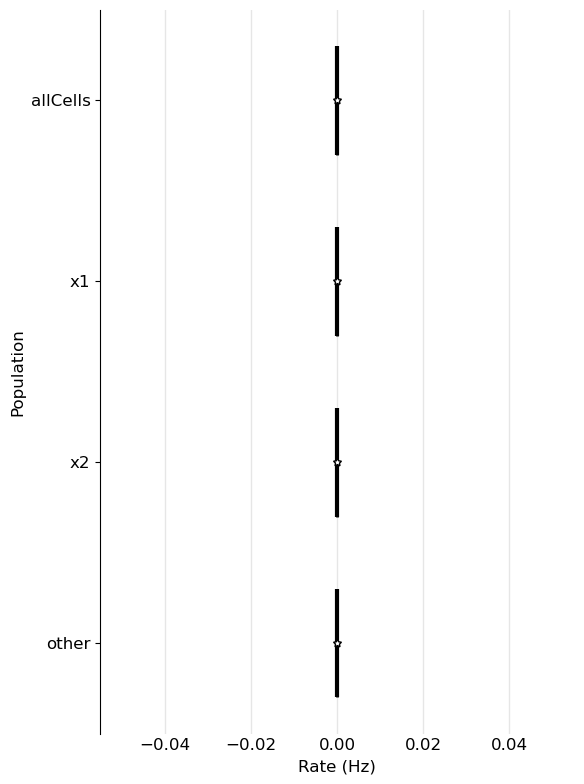

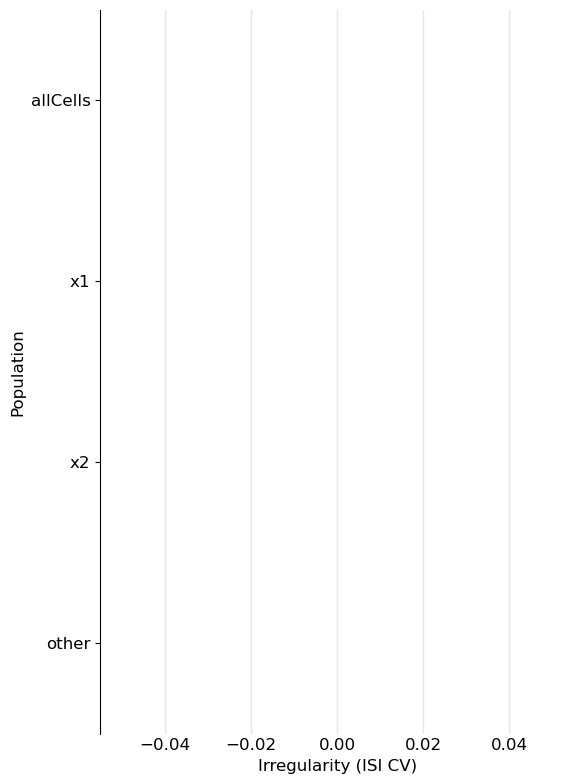

Error: plotSpikeStats() requires the PySpike python package                             to calculate synchrony (try: pip install pyspike)
  Done; plotting time = 0.23 s

Total time = 3.12 s


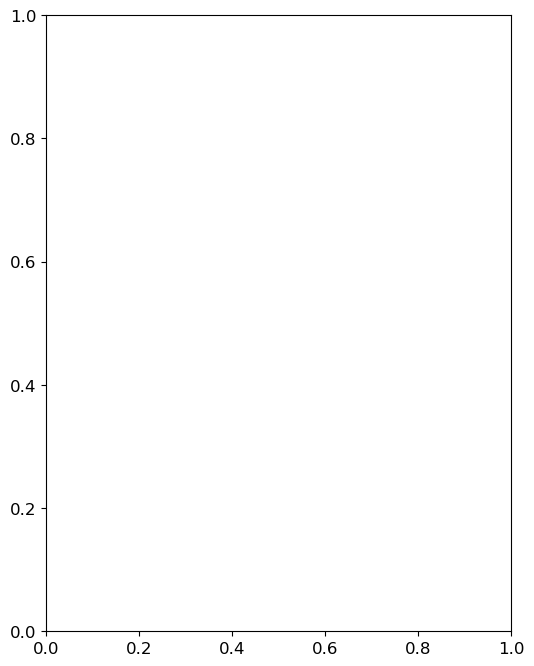

In [10]:
# Create network and run simulation
sim.createSimulateAnalyze(netParams=netParams, simConfig=simConfig)

## Analysis

In [11]:
# Extract the data
spike_times = sim.allSimData['spkt']
spike_ids = sim.allSimData['spkid']

# Compute firing rates for x1 and x2 populations
from netpyne.analysis.spikes import calculateRates

rates = calculateRates(timeRange=[0, simConfig.duration])

# Extract and plot ramping activity
x1_cells = sim.net.allPops['x1']['cellGids']
x1_rates = [rates[gid] for gid in x1_cells]

plt.figure()
plt.plot(x1_rates)
plt.title('Ramping Activity of x1 Neurons')
plt.xlabel('Neuron Index')
plt.ylabel('Firing Rate (Hz)')
plt.show()

ImportError: cannot import name 'calculateRates' from 'netpyne.analysis.spikes' (/home/charlesxu/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/netpyne/analysis/spikes.py)